# Benchmark Runner
After the prep work is done you can run the benchmark. First, pick your computer of choice.

In [1]:
import ipywidgets as widgets
w = widgets.Dropdown(options=["ims", "fugaku", "hokusai",
                              "hokudai", "archer2"],
                     description="Computer:")
display(w)

Dropdown(description='Computer:', options=('ims', 'fugaku', 'hokusai', 'hokudai', 'archer2'), value='ims')

Then we have to do some basic configuration.

In [2]:
from remotemanager import Dataset
from remotemanager.transport import rsync, scp

from time import sleep
from os.path import join

from remotemanager import Logger
Logger.path = 'benchmark_remotemanager_log'
Logger.level = 'debug'

computer = w.value

indir = "inp"
natoms = 54  # number of atoms in a molecule

# Small System to Compute
geom = "2CzPN_2"

# Large Systems to Compute
geoms = ["2CzPN_14", "2CzPN_18", "2CzPN_22", "2CzPN_26",
         "2CzPN_30", "2CzPN_34", "2CzPN_38", "2CzPN_42",
         "2CzPN_50", "2CzPN_58", "2CzPN_66", "2CzPN_74",
         "2CzPN_82", "2CzPN_90", "2CzPN_98", "2CzPN_106",
         "2CzPN_114", "2CzPN_122", "2CzPN_138", "2CzPN_154"
        ]

In [3]:
%load_ext remotemanager

Setup your computer.

In [4]:
transport = None
from ims import IMS, IMSLogin
from remotemanager import URL
url = IMS(user="anp")
url.mpi = 1
url.omp = 1
url.time = 1800
url.path_to_bigdft = "/home/users/anp/binaries/gcc"
remote_dir = join("runs", "2023", "benchmark-technical")

furl = IMSLogin(user="anp",)
furl.path_to_bigdft = "/home/users/anp/binaries/gcc"

# For scanning the MPI/OMP choices
mpi_omp = [(4, 32), (8, 16), (16, 8), (32, 4), (64, 2)]

# Parameters for the large calculations
large_mpi = 128
large_omp = 8
large_elapse = 14400

Set transport to rsync if not overridden

In [5]:
if transport is None:
    transport = rsync(url)

Validate that the url is working

In [6]:
url.cmd('ls')

binaries
devel
runs
temp_runner_remote

A routine that runs a calculation using the correct parameters for benchmarking.

In [7]:
def treat_system(sname, mpi, omp, indir=indir, linear=False):
    from BigDFT.IO import read_pdb
    from BigDFT.Inputfiles import Inputfile
    from BigDFT.Calculators import SystemCalculator
    from os.path import join
    
    # System
    with open(join(indir, sname + ".pdb")) as ifile:
        sys = read_pdb(ifile)
    
    # Input
    inp = Inputfile()
    inp.set_xc("PBE")
    inp.set_hgrid(0.5)
    inp.set_rmult(coarse=5.0, fine=7.0)
    inp.set_psp_nlcc()
    
    if linear:
        inp["import"] = "linear"
        inp["perf"] = {"check_sumrho": 0, "check_overlap": 0}
        inp["lin_general"] = {"charge_multipoles": 0, "output_mat": 0}
    
    # Compute
    calc = SystemCalculator(skip=True)
    
    # Determine the run name
    run_name = sname + "_" + str(mpi) + "_" + str(omp)
    log = calc.run(sys=sys, input=inp, name=run_name)

## Cubic Single Node Performance
The first benchmark checks the single node performance using a few combinations of threads and mpi ranks.

In [8]:
single_ds = Dataset(function = treat_system,
                    url = url, 
                    transport = transport,
                    extra_files_send=[indir],
                    dbfile="single_db_" + computer)

Add runs with each parameter.

In [9]:
for comb in mpi_omp:
    args = {"sname": geom, "mpi": comb[0], "omp": comb[1]}
    single_ds.append_run(arguments = args, mpi=comb[0], omp=comb[1],
                         remote_dir=remote_dir)

runner runner-5 already exists
runner runner-5 already exists
runner runner-5 already exists
runner runner-5 already exists
runner runner-5 already exists


In [10]:
single_ds.run()

assessing run for runner dataset-eb2cdea7-runner-0... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-1... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-2... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-3... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-4... skipping already submitted run


In [11]:
while not single_ds.all_finished:
    print('not finished, sleeping')
    sleep(120)

checking remotely for finished runs


Fetch the time to solution data.

In [12]:
%%sanzu url=furl, transport=transport
%%sanzu remote_dir=remote_dir, dbfile="single_fetch_" + computer 
%%sargs mpi_omp=mpi_omp, sname=geom
from yaml import load, SafeLoader
data = {}
for r in mpi_omp:
    rname = sname + "_" + str(r[0]) + "_" + str(r[1])
    with open("time-" + rname + ".yaml") as ifile:
        full = load(ifile, Loader=SafeLoader)
    data[rname] = {"time": full["WFN_OPT"]["Classes"]["Total"][1]}
data

runner runner-1 already exists
assessing run for runner dataset-f9cbc0b6-runner-0... skipping already completed run
checking remotely for finished runs


In [13]:
times = magic_dataset.results[0]

Plot.

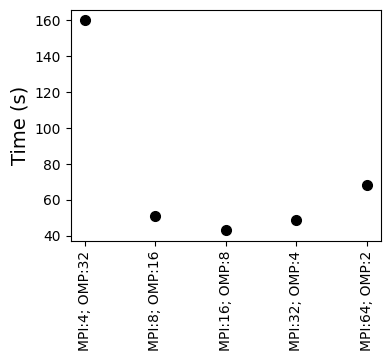

In [14]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
axs.plot([x["time"] for x in times.values()] , 'k.', markersize=14)
axs.set_ylabel("Time (s)", fontsize=14)
axs.set_xticks(range(len(list(times))))
axs.set_xticklabels(["MPI:" + str(comb[0]) + 
                     "; OMP:" + str(comb[1]) 
                     for comb in mpi_omp], rotation=90)
pass

## Linear Scaling Calculations
We will now switch to the linear scaling mode. We will run calculations of various size on a reasonable sized partition, and examine the performance.

In [15]:
LVC_set = Dataset(function = treat_system,
                  url = url, dbfile="scale_db_" + computer)
url.time = large_elapse

In [16]:
for g in geoms:
    args = {"sname": g, "mpi": large_mpi, "omp": large_omp, "linear": True}
    LVC_set.append_run(arguments = args, remote_dir=remote_dir,
                       mpi=large_mpi, omp=large_omp)

runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists
runner runner-20 already exists


In [17]:
LVC_set.run()

assessing run for runner dataset-eb2cdea7-runner-0... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-1... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-10... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-11... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-12... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-13... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-14... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-15... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-16... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-17... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-18... skipping already submitted run
assessing run for runner dataset-eb2cdea7-runner-19... s

In [18]:
while not single_ds.all_finished:
    sleep(120)

checking remotely for finished runs


Fetch the times.

In [19]:
%%sanzu url=furl, remote_dir=remote_dir
%%sanzu dbfile="scale_fetch_" + computer
%%sargs geoms=geoms, mpi=large_mpi, omp=large_omp
from yaml import load, SafeLoader
timing = {}
for g in geoms:
    run_name = g + "_" + str(mpi) + "_" + str(omp)
    with open("time-" + run_name + ".yaml") as ifile:
        full = load(ifile, Loader=SafeLoader)
    timing[run_name] = {"time": full["WFN_OPT"]["Classes"]["Total"][1]}

memory = {}
for g in geoms:
    run_name = g + "_" + str(mpi) + "_" + str(omp)
    with open("log-" + run_name + ".yaml") as ifile:
        full = load(ifile, Loader=SafeLoader)
    memory[run_name] = full["Memory Consumption Report"]["Memory occupation"]["Peak Value (MB)"]
timing, memory

runner runner-1 already exists
assessing run for runner dataset-3fb55c52-runner-0... skipping already completed run
checking remotely for finished runs


In [20]:
magic_dataset.fetch_results()
times, memory = magic_dataset.results[0]

checking remotely for finished runs


Plot the time vs. number of atoms.

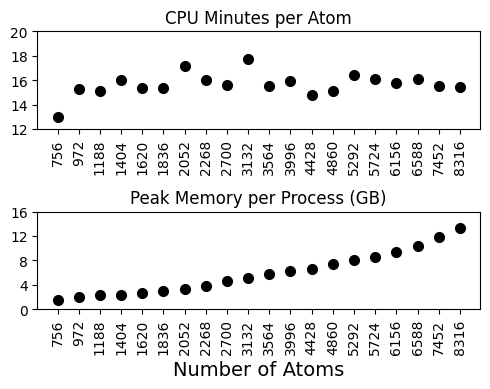

In [33]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(5, 4))
nats = [int(x.split("_")[-1])*54 for x in geoms]
minutes = [times[x + "_" + str(large_mpi) + 
                 "_" + str(large_omp)]["time"]/60 for x in geoms]
axs[0].plot([(m/a) * large_mpi*large_omp 
            for m, a in zip(minutes, nats)] , 
            'k.', markersize=14, label="Time")
axs[0].set_title("CPU Minutes per Atom", fontsize=12)
axs[0].set_xticks(range(len(list(times))))
axs[0].set_xticklabels(nats, rotation=90)
axs[0].set_yticks(range(12, 22, 2))

mem = [memory[x + "_" + str(large_mpi) + 
             "_" + str(large_omp)] for x in geoms]
axs[1].plot([m / 1024
            for m, a in zip(mem, nats)] , 
           'k.', markersize=14, label="Memory")
axs[1].set_xlabel("Number of Atoms", fontsize=14)
axs[1].set_title("Peak Memory per Process (GB)", fontsize=12)
axs[1].set_xticks(range(len(list(times))))
axs[1].set_xticklabels(nats, rotation=90)
axs[1].set_yticks(range(0, 20, 4))

# axs.legend()
fig.tight_layout()
fig.savefig("benchmark.png", dpi=300)
pass